# Study on Accessibility and Quality of Life in Medellín

## Impact on Tourists and Residents

Analysis of neighborhoods

Authors: Diego Donoso/ Camilo Nuñez /Francisco Torres

Install required Libraries

In [2]:
!pip install esda geopandas libpysal shapely mapclassify

In [ ]:
import os
import pandas as pd
pd.set_option('display.max_columns', 500)
import esda
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import libpysal as lps
from esda import Moran
import datetime
import matplotlib.pyplot as plt
from pyproj import CRS
import seaborn as sns
import mapclassify as mc
from matplotlib import colors
import itertools
from esda.moran import Moran_BV
from esda.moran import Moran_Local_BV
from matplotlib import colors
from matplotlib.lines import Line2D


### Databases processing

In [ ]:
gdf_comunas_shape = gpd.read_file('./DATA/DATASETS/MAPA/limite_catastral_de_comun.geojson', crs=CRS("WGS84"))
barrios = gpd.read_file('./DATA/DATASETS/MAPA/barrios_y_veredas.geojson', crs=CRS("WGS84"))
atractivos_turisticos = gpd.read_file('./DATA/DATASETS/Turismo/atractivos_turisticos.geojson', crs=CRS("WGS84"))
metricas_hoteles = gpd.read_file('./DATA/DATASETS/GEOJSON/metricas_hoteles.geojson', crs=CRS("WGS84"))
metricas_residentes = gpd.read_file('./DATA/DATASETS/GEOJSON/metricas_residentes.geojson', crs=CRS("WGS84"))
gdf_estrato = gpd.read_file('./DATA/DATASETS/geojson_estrato_socioeconomico/estrato_socioeconomico.geojson', crs=CRS("WGS84"))

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


In [7]:
hoteles_cols = list(filter(lambda x: '_Min' in x or '_Count' in x, metricas_hoteles.columns)) + ['geometry']
residentes_cols = list(filter(lambda x: '_Min' in x or '_Count' in x, metricas_residentes.columns)) + ['geometry']

In [8]:
barrios = barrios.rename(columns={'codigo': 'comuna'})
gdf_comunas = barrios

In [9]:
metricas_hoteles = metricas_hoteles.to_crs(gdf_comunas.crs)
metricas_residentes = metricas_residentes.to_crs(gdf_comunas.crs)

In [10]:
gdf_hoteles = metricas_hoteles[hoteles_cols]
gdf_residentes = metricas_residentes[residentes_cols]

gdf_hoteles = gdf_hoteles.apply(lambda x: x.astype('float64') if x.name != 'geometry' else x)
gdf_residentes = gdf_residentes.apply(lambda x: x.astype('float64') if x.name != 'geometry' else x)

In [ ]:
def load_geodf(filename, latitude='latitud', longitude='longitud', time_variable=None, min_date=None):
    """ 
    Load GeoDataframe and project to the main shape file
    """
    df = pd.read_csv(filename)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[longitude], df[latitude]), crs=CRS("WGS84"))
    if time_variable:
        gdf[time_variable] = pd.to_datetime(gdf[time_variable])

        if min_date:
            gdf = gdf[(gdf[time_variable] >= min_date)]
    gdf = gdf.dropna(subset=[latitude, longitude])
    if gdf_comunas.crs != gdf.crs:
        gdf = gdf.to_crs(gdf_comunas.crs)
    return gdf

In [12]:
def clean_dir(dir):
    for d in os.listdir(dir):
        os.remove(f'{dir}/{d}')

In [13]:
start_date = pd.Timestamp(datetime.datetime(2023, 1, 1)).tz_localize("America/Bogota")
homicidios = load_geodf(r'./DATA/DATASETS/Delincuencia/homicidio.csv', time_variable='fecha_hecho', min_date=start_date)
start_date = pd.Timestamp(datetime.datetime(2021, 1, 1)).tz_localize("America/Bogota")
secuestros = load_geodf(r'./DATA/DATASETS/Delincuencia/secuestro.csv', time_variable='fecha_hecho', min_date=start_date)
start_date = pd.Timestamp(datetime.datetime(2022, 1, 1)).tz_localize("America/Bogota")
hurtos = load_geodf(r'./DATA/DATASETS/Delincuencia/hurto_a_persona.csv', time_variable='fecha_hecho', min_date=start_date)
hurto_carro = load_geodf(r'./DATA/DATASETS/Delincuencia/hurto_de_carro.csv', time_variable='fecha_hecho', min_date=start_date)
start_date = pd.Timestamp(datetime.datetime(2022, 1, 1)).tz_localize("America/Bogota")
accidentes = load_geodf(r'./DATA/DATASETS/AccidentesTrafico/lesion_fatal_accidente_de_transito_segun_policia.csv', time_variable='fecha_hecho', min_date=start_date)

/tmp/ipykernel_25911/2591045331.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [ ]:
def plot_geodf(gdf, column, ax):
    """ 
    Plot aggregated data on neighborhood and show communes
    """
    gdf.plot(column=column, cmap="Reds", linewidth=0.4, edgecolor="black", legend=True, ax=ax)
    gdf_comunas_shape.boundary.plot(linewidth=1, edgecolor="black", ax=ax)

In [ ]:
def comunalizar(gdf, group_name='comuna', agg_name='count'):
    """ 
    Aggregate a GeoDataframe to a neighborhood level counting the values
    """
    by_district = gpd.sjoin(gdf, gdf_comunas, how="inner", predicate="within")
    return by_district.groupby(group_name).size().reset_index(name=agg_name)


In [ ]:
def comunalizar_mult(gdf, cols, group_name='comuna', prefix='col_'):
    """ 
    Aggregate a GeoDataframe to a neighborhood level on multiple columns by mean
    """
    by_district = gpd.sjoin(gdf, gdf_comunas, how="inner", predicate="within")
    by_district = by_district.groupby(group_name)[cols].mean().reset_index()
    by_district.columns = ['comuna'] + [prefix + col for col in by_district.columns.difference(['comuna'])]
    return by_district

In [24]:
gdf_hoteles_com = comunalizar_mult(gdf_hoteles, gdf_hoteles.columns.difference(['geometry']), prefix='Turista_')
gdf_residentes_com = comunalizar_mult(gdf_residentes, gdf_residentes.columns.difference(['geometry']), prefix='Residente_')

In [25]:
homicidios_com = comunalizar(homicidios)
secuestros_com = comunalizar(secuestros)
hurtos_com = comunalizar(hurtos)
hurtos_carro_com = comunalizar(hurto_carro)
atractivos_com = comunalizar(atractivos_turisticos)
accidentes_com = comunalizar(accidentes)

### Visualization of aggregated data

In [26]:
def append_comuna(df, init_gdf=gdf_comunas, name='x', nombre='comuna'):
    return init_gdf.merge(df.rename(columns={'count': f'{name}_count'}), on=nombre, how='left').fillna(0)

In [27]:
gdf_summary = append_comuna(homicidios_com, name='homicidios')
gdf_summary = append_comuna(secuestros_com, init_gdf=gdf_summary, name='secuestros')
gdf_summary = append_comuna(hurtos_com, init_gdf=gdf_summary, name='hurtos')
gdf_summary = append_comuna(hurtos_carro_com, init_gdf=gdf_summary, name='hurto_carro')
gdf_summary = append_comuna(atractivos_com, init_gdf=gdf_summary, name='atractivos_turisticos')
gdf_summary = append_comuna(accidentes_com, init_gdf=gdf_summary, name='accidentes')

In [28]:
gdf_summary = gdf_summary.merge(gdf_hoteles_com, on='comuna', how='left')
gdf_summary = gdf_summary.merge(gdf_residentes_com, on='comuna', how='left')

(np.float64(4697890.650535001),
 np.float64(4727957.534964999),
 np.float64(2238554.9945549998),
 np.float64(2264346.594345))

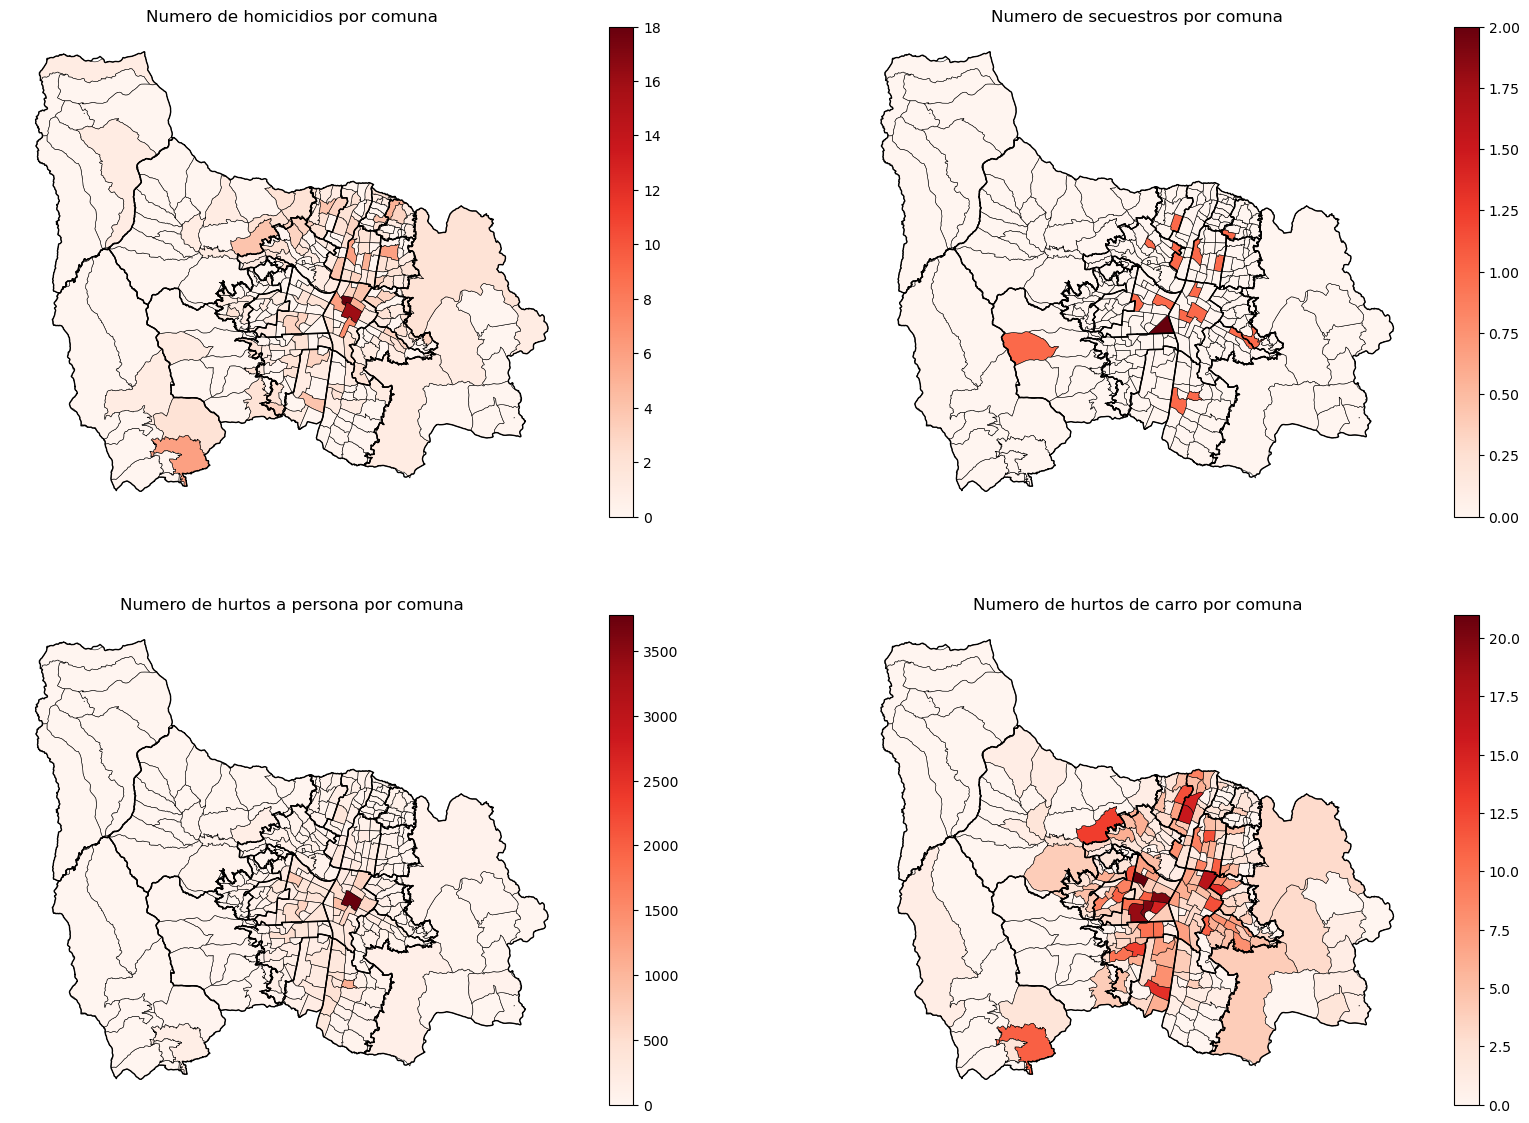

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]
# Set titles for each subplot
ax1.set_title("Numero de homicidios por comuna")
ax2.set_title("Numero de secuestros por comuna")
ax3.set_title("Numero de hurtos a persona por comuna")
ax4.set_title("Numero de hurtos de carro por comuna")
# ax4.set_title("Estrato mediano por comuna")

plot_geodf(gdf_summary, 'homicidios_count', ax1)
plot_geodf(gdf_summary, 'secuestros_count', ax2)
plot_geodf(gdf_summary, 'hurtos_count', ax3)
plot_geodf(gdf_summary, 'hurto_carro_count', ax4)

# gdf_summary.merge(gdf_estrato.groupby('comuna', as_index=False).agg(estrato=('estrato','median'))).plot(column="estrato", linewidth=0.8, edgecolor="black", legend=True, ax=ax4)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

(np.float64(4697890.650535001),
 np.float64(4727957.534964999),
 np.float64(2238554.9945549998),
 np.float64(2264346.594345))

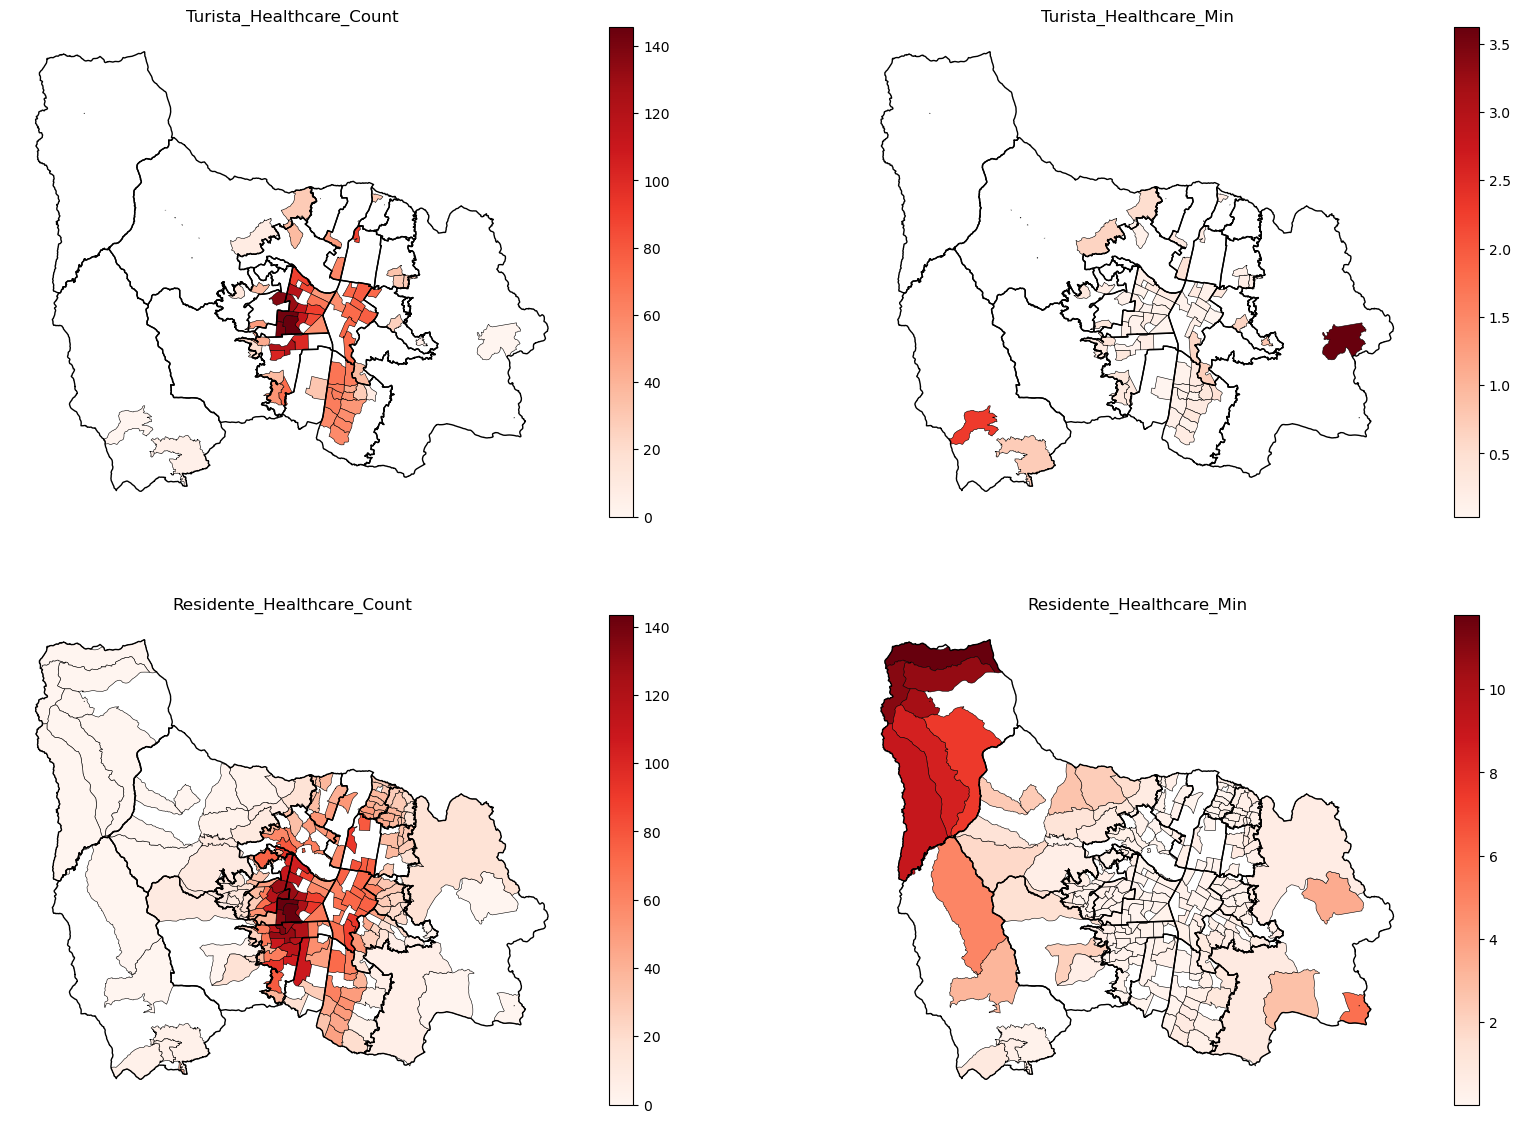

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]
# Set titles for each subplot
ax1.set_title("Turista_Healthcare_Count")
ax2.set_title("Turista_Healthcare_Min")
ax3.set_title("Residente_Healthcare_Count")
ax4.set_title("Residente_Healthcare_Min")
# ax4.set_title("Estrato mediano por comuna")

plot_geodf(gdf_summary, 'Turista_Healthcare_Count', ax1)
plot_geodf(gdf_summary, 'Turista_Healthcare_Min', ax2)
plot_geodf(gdf_summary, 'Residente_Healthcare_Count', ax3)
plot_geodf(gdf_summary, 'Residente_Healthcare_Min', ax4)

# gdf_summary.merge(gdf_estrato.groupby('comuna', as_index=False).agg(estrato=('estrato','median'))).plot(column="estrato", linewidth=0.8, edgecolor="black", legend=True, ax=ax4)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

In [33]:
estratos = gdf_summary.merge(gdf_estrato.groupby('comuna', as_index=False).agg(estrato=('estrato','median')).rename(columns={'comuna':'corregimiento'}), left_on='limitecomunacorregimientoid', right_on='corregimiento')

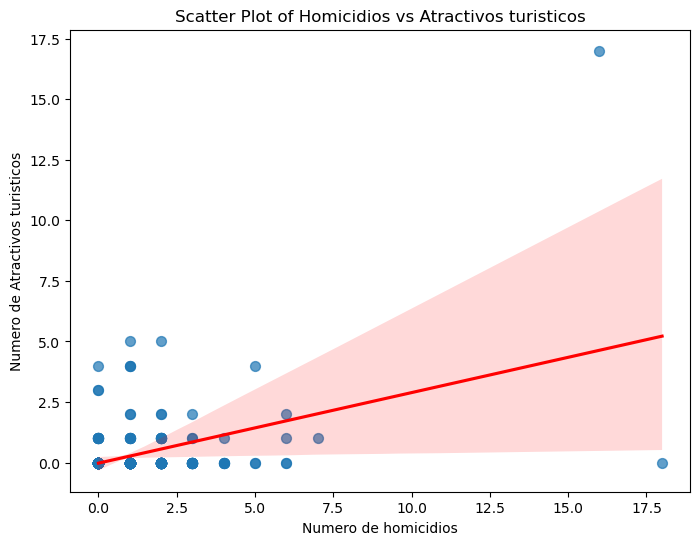

In [36]:
# Scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    data=estratos,
    x="homicidios_count",
    y="atractivos_turisticos_count",
    scatter_kws={"s": 50, "alpha": 0.7},
    line_kws={"color": "red"}
)
plt.title("Scatter Plot of Homicidios vs Atractivos turisticos")
plt.xlabel("Numero de homicidios")
plt.ylabel("Numero de Atractivos turisticos")
plt.show()

In [39]:
encuesta = pd.read_csv('./DATA/DATASETS/indice_multidimensional_encuesta_calidad_de_vida.csv')

In [41]:
encuesta['corregimiento'] = encuesta['varcharidcomunafk'].astype(str).str.zfill(2)

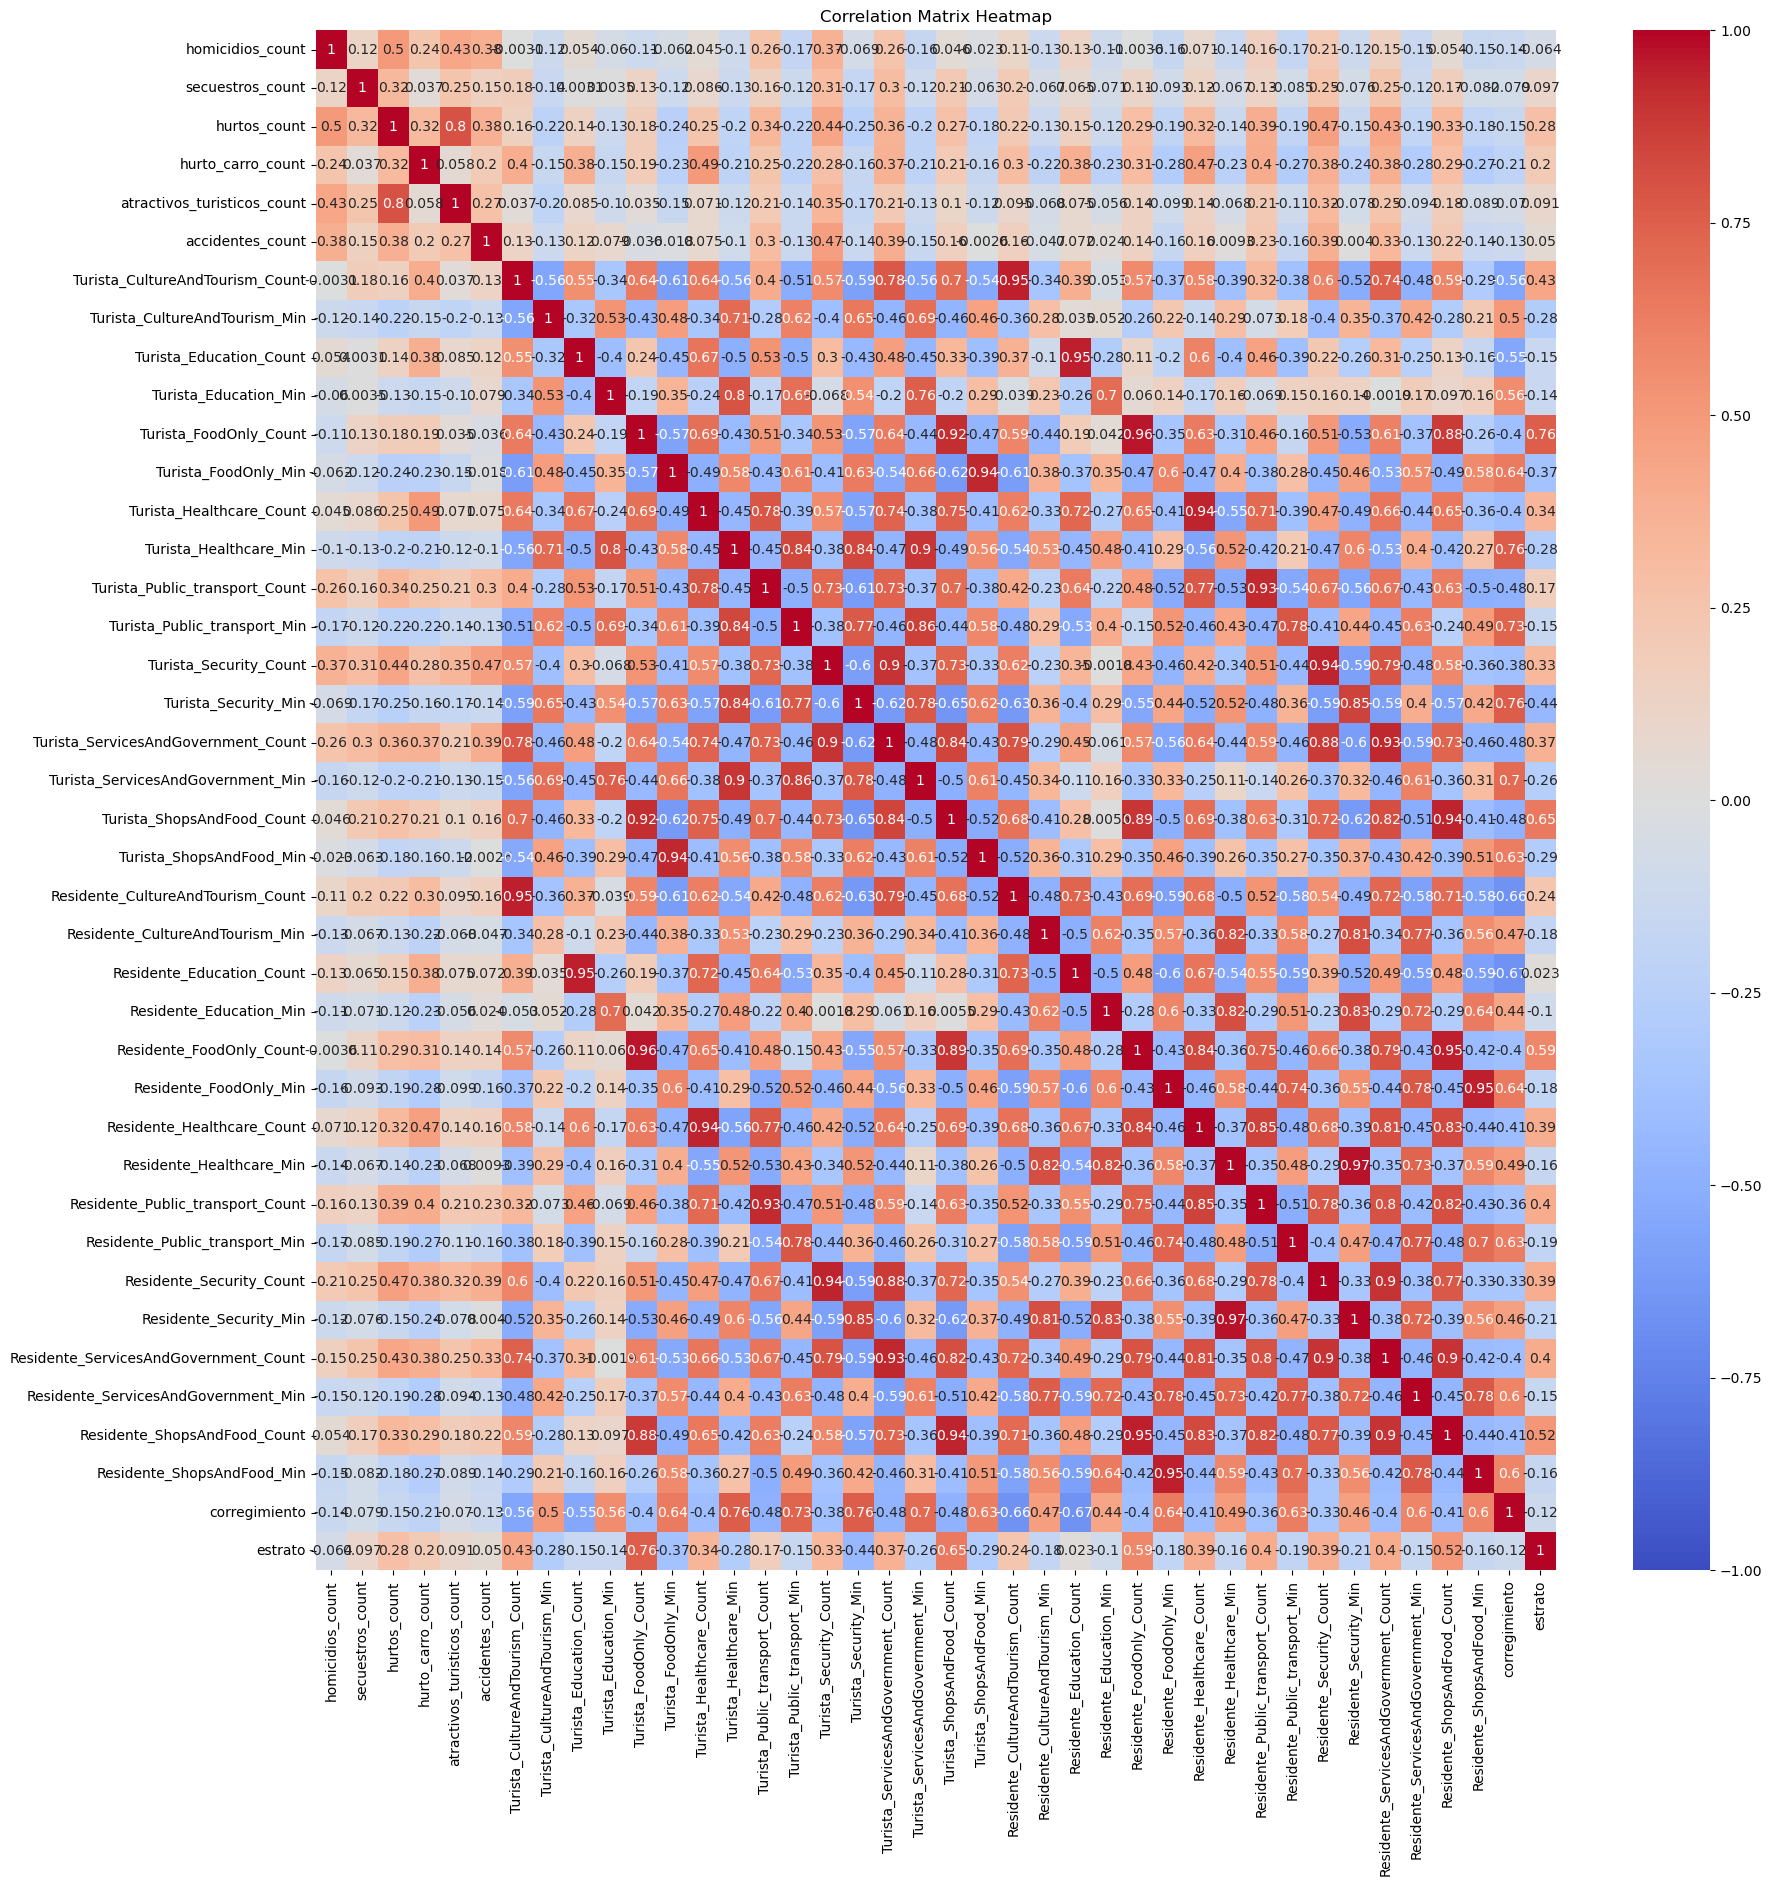

In [43]:
corr_matrix = estratos.drop(['OBJECTID', 'comuna', 'sector', 'nombre', 'identificacion', 'limitecomunacorregimientoid', 'limitemunicipioid', 'subtipo_barriovereda', 'fecha_sincronizacion','Shape_Length', 'Shape_Area', 'geometry', 'intaño', 'varcharidcomunafk'], axis=1, errors='ignore').corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [44]:
cols = estratos.drop(['OBJECTID', 'comuna', 'sector', 'nombre', 'identificacion', 'limitecomunacorregimientoid', 'limitemunicipioid', 'subtipo_barriovereda', 'fecha_sincronizacion','Shape_Length', 'Shape_Area', 'geometry', 'intaño', 'varcharidcomunafk', 'corregimiento'], axis=1, errors='ignore').columns

In [118]:
labels  = {
    "homicidios_count": "Number of homicides",
    "secuestros_count": "Number of kidnappings",
    "hurtos_count": "Number of pickpocketing incidents",
    "hurto_carro_count": "Number of car thefts",
    "atractivos_turisticos_count": "Number of tourist attractions",
    "accidentes_count": "Number of fatal accidents",
    "Turista_CultureAndTourism_Count": "Number of cultural and tourist attractions near a hotel",
    "Turista_CultureAndTourism_Min": "The closest cultural and tourist attraction to the hotel",
    "Turista_Education_Count": "Number of educational institutions near a hotel",
    "Turista_Education_Min": "The closest educational institution to the hotel",
    "Turista_FoodOnly_Count": "Number of food-related attractions near a hotel",
    "Turista_FoodOnly_Min": "The closest food-related attraction to the hotel",
    "Turista_Healthcare_Count": "Number of healthcare facilities near a hotel",
    "Turista_Healthcare_Min": "The closest healthcare facility to the hotel",
    "Turista_Public_transport_Count": "Number of public transport options near a hotel",
    "Turista_Public_transport_Min": "The closest public transport option to the hotel",
    "Turista_Security_Count": "Number of security-related places near a hotel",
    "Turista_Security_Min": "The closest security-related place to the hotel",
    "Turista_ServicesAndGovernment_Count": "Number of service and government institutions near a hotel",
    "Turista_ServicesAndGovernment_Min": "The closest service or government institution to the hotel",
    "Turista_ShopsAndFood_Count": "Number of shops and food-related places near a hotel",
    "Turista_ShopsAndFood_Min": "The closest shop or food-related place to the hotel",
    "Residente_CultureAndTourism_Count": "Number of cultural and tourist attractions near a residence",
    "Residente_CultureAndTourism_Min": "The closest cultural and tourist attraction to the residence",
    "Residente_Education_Count": "Number of educational institutions near a residence",
    "Residente_Education_Min": "The closest educational institution to the residence",
    "Residente_FoodOnly_Count": "Number of food-related attractions near a residence",
    "Residente_FoodOnly_Min": "The closest food-related attraction to the residence",
    "Residente_Healthcare_Count": "Number of healthcare facilities near a residence",
    "Residente_Healthcare_Min": "The closest healthcare facility to the residence",
    "Residente_Public_transport_Count": "Number of public transport options near a residence",
    "Residente_Public_transport_Min": "The closest public transport option to the residence",
    "Residente_Security_Count": "Number of security-related places near a residence",
    "Residente_Security_Min": "The closest security-related place to the residence",
    "Residente_ServicesAndGovernment_Count": "Number of service and government institutions near a residence",
    "Residente_ServicesAndGovernment_Min": "The closest service or government institution to the residence",
    "Residente_ShopsAndFood_Count": "Number of shops and food-related places near a residence",
    "Residente_ShopsAndFood_Min": "The closest shop or food-related place to the residence",
    'estrato': "Stratum of communes"
}

escala  = {
    "homicidios_count": "[Count]",
    "secuestros_count": "[Count]",
    "hurtos_count": "[Count]",
    "hurto_carro_count": "[Count]",
    "atractivos_turisticos_count": "[Count]",
    "accidentes_count": "[Count]",
    "Turista_CultureAndTourism_Count": "[Count]",
    "Turista_CultureAndTourism_Min": "[Average distance Km]",
    "Turista_Education_Count": "[Count]",
    "Turista_Education_Min": "[Average distance Km]",
    "Turista_FoodOnly_Count": "[Count]",
    "Turista_FoodOnly_Min": "[Average distance Km]",
    "Turista_Healthcare_Count": "[Count]",
    "Turista_Healthcare_Min": "[Average distance Km]",
    "Turista_Public_transport_Count": "[Count]",
    "Turista_Public_transport_Min": "[Average distance Km]",
    "Turista_Security_Count": "[Count]",
    "Turista_Security_Min": "[Average distance Km]",
    "Turista_ServicesAndGovernment_Count": "[Count]",
    "Turista_ServicesAndGovernment_Min": "[Average distance Km]",
    "Turista_ShopsAndFood_Count": "[Count]",
    "Turista_ShopsAndFood_Min": "[Average distance Km]",
    "Residente_CultureAndTourism_Count": "[Count]",
    "Residente_CultureAndTourism_Min": "[Average distance Km]",
    "Residente_Education_Count": "[Count]",
    "Residente_Education_Min": "[Average distance Km]",
    "Residente_FoodOnly_Count": "[Count]",
    "Residente_FoodOnly_Min": "[Average distance Km]",
    "Residente_Healthcare_Count": "[Count]",
    "Residente_Healthcare_Min": "[Average distance Km]",
    "Residente_Public_transport_Count": "[Count]",
    "Residente_Public_transport_Min": "[Average distance Km]",
    "Residente_Security_Count": "[Count]",
    "Residente_Security_Min": "[Average distance Km]",
    "Residente_ServicesAndGovernment_Count": "[Count]",
    "Residente_ServicesAndGovernment_Min": "[Average distance Km]",
    "Residente_ShopsAndFood_Count": "[Count]",
    "Residente_ShopsAndFood_Min": "[Average distance Km]",
    'estrato': "[Socioeconomic stratum]"
}

In [66]:
clean_dir(f'./outs/visualizacion')

for col in cols:
    fig, ax = plt.subplots(figsize=(10, 7))

    # Set titles for each subplot
    ax.set_title(f"{labels[col]},\n Aggregation by Medellín neighborhoods")
    # ax4.set_title("Estrato mediano por comuna")

    cmap = estratos.plot(column=col, cmap="Reds", linewidth=0.4, edgecolor="black", legend=False, ax=ax)
    gdf_comunas_shape.boundary.plot(linewidth=1, edgecolor="black", ax=ax)

    cbar = plt.colorbar(cmap.collections[0], ax=ax, orientation="vertical")
    cbar.set_label(f"{escala[col]}")  # Add custom label for the colorbar

    # gdf_summary.merge(gdf_estrato.groupby('comuna', as_index=False).agg(estrato=('estrato','median'))).plot(column="estrato", linewidth=0.8, edgecolor="black", legend=True, ax=ax4)
    ax.axis('off')
    plt.savefig(f'./outs/visualizacion/{col}.png')
    plt.close()

### Spatial Analysis

Spatial correlation using Moran Index

In [67]:
df = estratos.copy()  # Ejemplo de nombre de DataFrame

# Crear matriz de pesos espaciales usando vecinos de la Reina
wq = lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

/tmp/ipykernel_25911/2353463311.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


In [68]:
variables = cols
moran_results = {}

for var in variables:
    moran = esda.Moran(df[var], wq)
    moran_results[var] = {"I": moran.I, "p-value": moran.p_norm}

moran_res = pd.DataFrame(moran_results).T.sort_values('p-value', ascending=True)

In [69]:
moran_res[(moran_res['p-value'] <= 0.05) & (abs(moran_res['I']) > 0.2)]

,I,p-value
estrato,0.802256,3.917259e-134
hurto_carro_count,0.345886,1.269667e-26
hurtos_count,0.289054,3.890991e-19
homicidios_count,0.240052,1.004949e-13
accidentes_count,0.211242,5.436507e-11


Bivariate analysis

In [71]:
bivariate_results = {}

combinaciones = list(itertools.combinations(cols, 2))

# Comparar cada par de variables
for var1, var2 in combinaciones:
    bivariate_moran = esda.Moran_BV(df[var1], df[var2], wq)
    bivariate_results[f"{var1}-{var2}"] = {
        "I": bivariate_moran.I,
        "p-value": bivariate_moran.p_sim
    }

bivariate_results = pd.DataFrame(bivariate_results).T.sort_values('p-value', ascending=True)

In [72]:
bivariate_results[(bivariate_results['p-value'] <= 0.05) & (abs(bivariate_results['I']) > 0.2)].sort_values('I', ascending=False)

,I,p-value
hurtos_count-estrato,0.243887,0.001
homicidios_count-hurtos_count,0.221039,0.001
hurtos_count-atractivos_turisticos_count,0.220056,0.001


In [143]:
def autocorrelacion_espacial(df, col):
    wq =  lps.weights.Queen.from_dataframe(df)
    wq.transform = 'r'
    y = df[col]
    ylag = lps.weights.lag_spatial(wq, y)

    yb = y > y.median()
    labels_ = ["0 Low", "1 High"]
    yb = [labels_[i] for i in 1*yb]
    df['yb'] = yb

    yb = 1 * (y > y.median()) # convert back to binary
    wq =  lps.weights.Queen.from_dataframe(df)
    wq.transform = 'b'
    np.random.seed(12345)
    jc = esda.join_counts.Join_Counts(yb, wq)

    wq.transform = 'r'
    lag_hom = lps.weights.lag_spatial(wq, df[col])

    hom = df[col]
    b, a = np.polyfit(hom, lag_hom, 1)
    f, ax = plt.subplots(1, figsize=(9, 9))

    plt.plot(hom, lag_hom, '.', color='firebrick')
    # dashed vert at mean of the price
    plt.vlines(hom.mean(), lag_hom.min(), lag_hom.max(), linestyle='--')
    # dashed horizontal at mean of lagged price
    plt.hlines(lag_hom.mean(), hom.min(), hom.max(), linestyle='--')

    # red line of best fit using global I as slope
    plt.plot(hom, a + b*hom, 'r')
    plt.title('Moran Scatterplot')
    plt.ylabel(f'Spatial Lag of {col}')
    plt.xlabel(f'{col}')
    plt.savefig(f'./outs/autocorrelacion/scatter_{col}.png')
    plt.close()

    li = esda.moran.Moran_Local(y, wq)

    sig = 1 * (li.p_sim < 0.05)
    hotspot = 1 * (sig * li.q==1)
    coldspot = 3 * (sig * li.q==3)
    doughnut = 2 * (sig * li.q==2)
    diamond = 4 * (sig * li.q==4)
    spots = hotspot + coldspot + doughnut + diamond
    
    spot_labels_text = ['No Spatial Autocorrelation', 'High values surrounded by high values (cluster)', 'Low value surrounded by high values', 'Low values surrounded by low values (cluster)', 'High surrounded by low or vice versa']
    spot_labels = ['0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']

    labels_graph = [spot_labels[i] for i in spots]
    colorset = []
    label_set = []
    colorlist = ['lightgrey', 'red', 'pink', 'blue', 'lightblue']
    for i in range(5):
        if i in spots:
            colorset.append(colorlist[i])
            label_set.append(spot_labels_text[i])
    hmap = colors.ListedColormap(colorset)

    f, ax = plt.subplots(1, figsize=(9, 9))
    df.assign(cl=labels_graph).plot(column='cl', categorical=True, \
            k=2, cmap=hmap, linewidth=0.1, ax=ax, \
            edgecolor='white', legend=False)
    gdf_comunas_shape.boundary.plot(linewidth=1, edgecolor="black", ax=ax)

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colorlist[i], markersize=10, label=spot_labels_text[i]) for i in range(5)]

    # Add the custom legend
    ax.legend(handles=legend_elements, title="Spatial Autocorrelation", bbox_to_anchor=(1, 1), loc='upper right')
    plt.title(f'Spatial Autocorrelation Analysis: {labels[col]},\n Aggregation by Medellín neighborhoods')
    ax.set_axis_off()


    plt.savefig(f'./outs/autocorrelacion/corr_{col}.png')
    plt.close()

In [144]:
clean_dir(f'./outs/autocorrelacion')

variables_cand = moran_res[(moran_res['p-value'] <= 0.05) & (abs(moran_res['I']) > 0.2)].reset_index()
for variable in variables_cand.iterrows():
    name = variable[1]['index']
    autocorrelacion_espacial(estratos, name)


/tmp/ipykernel_25911/1249218302.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)
/tmp/ipykernel_25911/1249218302.py:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)
/tmp/ipykernel_25911/1249218302.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)
/tmp/ipykernel_25911/1249218302.py:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)
/tmp/ipykernel_25911/1249218302.py:2: FutureWa

In [ ]:
def autocorrelacion_bivariada(df, col1, col2):
    # Definir la matriz de pesos espaciales (vecindad de reina)
    wq = lps.weights.Queen.from_dataframe(df)
    wq.transform = 'r'

    # Definir las dos variables a correlacionar
    y = df[col1]  # Variable objetivo
    x = df[col2]  # Variable secundaria

    # Calcular Moran Bivariado
    moran_bv = Moran_BV(y, x, wq)
    print(f"Índice de Moran Bivariado: {moran_bv.I}, p-value: {moran_bv.p_sim}")
    # Calcular Moran Local Bivariado
    local_bv = Moran_Local_BV(y, x, wq)

    # Determinar significancia
    sig = 1 * (local_bv.p_sim < 0.05)

    # Identificar hotspots, coldspots y otras categorías de autocorrelación espacial
    hotspot = 1 * (sig * local_bv.q==1)
    coldspot = 3 * (sig * local_bv.q==3)
    doughnut = 2 * (sig * local_bv.q==2)
    diamond = 4 * (sig * local_bv.q==4)
    spots = hotspot + coldspot + doughnut + diamond

    spot_labels = ['0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
    labels_graph = [spot_labels[i] for i in spots]
    spot_labels_text = ['No Spatial Autocorrelation', 'High values surrounded by high values (cluster)', 'Low value surrounded by high values', 'Low values surrounded by low values (cluster)', 'High surrounded by low or vice versa']
    
    colorset = []
    label_set = []
    colorlist = ['lightgrey', 'red', 'pink', 'blue', 'lightblue']
    for i in range(5):
        if i in spots:
            colorset.append(colorlist[i])
            label_set.append(spot_labels_text[i])

    # Crear un mapa de colores para los tipos de correlación espacial
    hmap = colors.ListedColormap(colorset)

    # Graficar los resultados en un mapa
    f, ax = plt.subplots(1, figsize=(9, 9))
    df.assign(cl=labels_graph).plot(column='cl', categorical=True, k=2, cmap=hmap, linewidth=0.1, ax=ax, edgecolor='white', legend=False)
    gdf_comunas_shape.boundary.plot(linewidth=1, edgecolor="black", ax=ax)

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colorlist[i], markersize=10, label=spot_labels_text[i]) for i in range(5)]
    ax.legend(handles=legend_elements, title="Spatial Bivariate Autocorrelation", bbox_to_anchor=(1, 1), loc='upper right')
    
    # Título y configuraciones del gráfico
    plt.title(f'Spatial Bivariate Autocorrelation Analysis:\n{labels[col1]} and {labels[col2]},\n Aggregation by Medellín neighborhoods')
    ax.set_axis_off()
    plt.savefig(f'./outs/bivariado/corr_{col1}_{col2}.png')
    plt.close()

In [152]:
bivariables = bivariate_results[(bivariate_results['p-value'] <= 0.05) & (abs(bivariate_results['I']) > 0.2)].sort_values('I', ascending=False).reset_index()

In [153]:
clean_dir(f'./outs/bivariado')

for variable in bivariables.iterrows():
    col1, col2 = variable[1]['index'].split('-')
    autocorrelacion_bivariada(estratos, col1, col2)

/tmp/ipykernel_25911/30769914.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


Índice de Moran Bivariado: 0.24388686394168496, p-value: 0.001


/tmp/ipykernel_25911/30769914.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


Índice de Moran Bivariado: 0.2210391819881167, p-value: 0.001


/tmp/ipykernel_25911/30769914.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


Índice de Moran Bivariado: 0.22005630961359934, p-value: 0.001
